Long Short-Term Memory (LSTM), Gated Recurrent Unit (GRU), and Bidirectional LSTM (BiLSTM) are three types of Recurrent Neural Networks that are extensively employed. I have compared these networks based on their effectiveness in forecasting the air pollutant PM10. After that, I make my projections for the coming time.

In [ ]:
import scipy
import numpy
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
from IPython.core.pylabtools import figsize

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns

# Set random seed for reproducibility
tf.random.set_seed(1234)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file = 'drive/MyDrive/Colab Notebooks/b2.csv'
raw_data = pd.read_csv(file, parse_dates = ['date'], index_col = 'date')

df = raw_data.copy()
print(df.head())

            PM2dot5    PM10     NO    NO2    NOx    NH3    SO2    CO  Ozone  \
date                                                                          
2019-01-01   151.12  515.67  56.88  54.95  75.44  74.42  18.54  2.51  27.43   
2019-01-02   257.21  625.60  58.90  73.14  86.91  81.71  21.16  3.00  31.07   
2019-01-03   141.07  515.14  22.73  44.50  42.12  75.25  16.18  2.02  17.08   
2019-01-04   222.49  383.30  18.52  36.10  34.29  53.20  15.61  1.88  12.88   
2019-01-05   309.92  494.91  18.40  58.23  45.92  49.80  15.43  2.10   3.63   

            Wind speed  
date                    
2019-01-01        0.64  
2019-01-02        0.84  
2019-01-03        0.97  
2019-01-04        0.80  
2019-01-05        1.33  


In [ ]:
df.describe()

,PM2dot5,PM10,NO,NO2,NOx,NH3,SO2,CO,Ozone,Wind speed
count,1026.000000,996.000000,1028.000000,1028.000000,1028.000000,1032.000000,1016.000000,1025.000000,1026.000000,365.000000
mean,118.970955,229.700748,9.980272,32.364110,26.534018,36.012524,11.248100,1.164990,38.311676,1.177671
std,94.117334,138.305529,13.281891,22.964907,19.223764,18.258039,7.584875,0.652307,22.022606,0.407871
min,13.450000,12.040000,0.450000,1.840000,3.660000,0.040000,1.260000,0.190000,3.500000,0.500000
25%,51.985000,119.867500,2.287500,16.027500,12.647500,23.152500,5.365000,0.730000,21.580000,0.900000
50%,87.720000,204.040000,4.480000,27.520000,20.095000,31.970000,8.980000,1.020000,33.110000,1.110000
75%,160.025000,311.057500,11.387500,42.680000,34.560000,44.295000,16.000000,1.460000,52.045000,1.390000
max,703.000000,810.940000,89.760000,188.580000,123.310000,121.590000,39.640000,5.900000,114.590000,3.030000


In [ ]:
df.shape

(1035, 10)

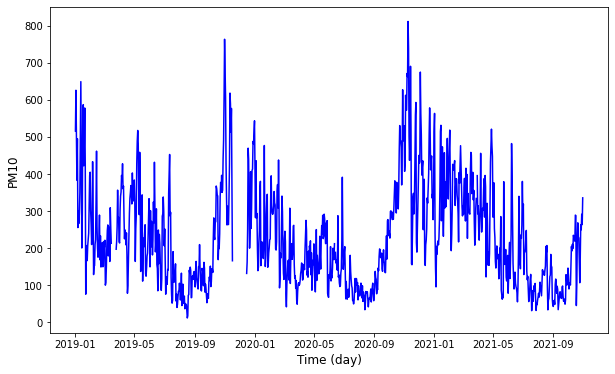

In [ ]:
# Define a function to draw time_series plot
def timeseries (x_axis, y_axis, x_label, y_label):
    plt.figure(figsize = (10, 6))
    plt.plot(x_axis, y_axis, color ='blue')
    plt.xlabel(x_label, {'fontsize': 12})
    plt.ylabel(y_label, {'fontsize': 12})

timeseries(df.index, df['PM10'], 'Time (day)', 'PM10')


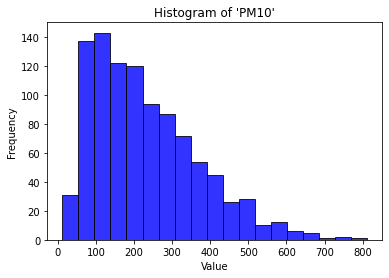

In [ ]:
def plot_histogram(x):
    plt.hist(x, bins = 19, alpha=0.8, color = 'blue', edgecolor = 'black')
    plt.title("Histogram of '{var_name}'".format(var_name=x.name))
    plt.xlabel("Value")
    plt.ylabel("Frequency")

plot_histogram(df['PM10'])

In [ ]:
#RENAME
#df = df.rename(columns = {'Max Temp (C)':'Max_T', 'Min Temp (C)':'Min_T','Total Precip (mm)':'T_P','WC (m3/capita.day)':'UWC'})

# Missing values
df.isnull().sum()

PM2dot5         9
PM10           39
NO              7
NO2             7
NOx             7
NH3             3
SO2            19
CO             10
Ozone           9
Wind speed    670
dtype: int64

In [ ]:
# Replace missing values by interpolation
def replace_missing (attribute):
    return attribute.interpolate(inplace=True)

replace_missing(df['PM2dot5'])
replace_missing(df['PM10'])
replace_missing(df['NO'])
replace_missing(df['NO2'])
replace_missing(df['NOx'])
replace_missing(df['NH3'])
replace_missing(df['SO2'])
replace_missing(df['CO'])
replace_missing(df['Ozone'])
replace_missing(df['Wind speed'])

#replace_missing(df['Humidity'])
#replace_missing(df['Temp'])

In [ ]:
# Outlier detection
up_b = df['PM10'].mean() + 2*df['PM10'].std()
low_b = df['PM10'].mean() - 2*df['PM10'].std()

# Replace outlier by interpolation for base consumption
df.loc[df['PM10'] > up_b, 'PM10'] = np.nan
df.loc[df['PM10'] < low_b, 'PM10'] = np.nan
df['PM10'].interpolate(inplace=True)

Dimension of train data:  (828, 10)
Dimension of test data:  (207, 10)


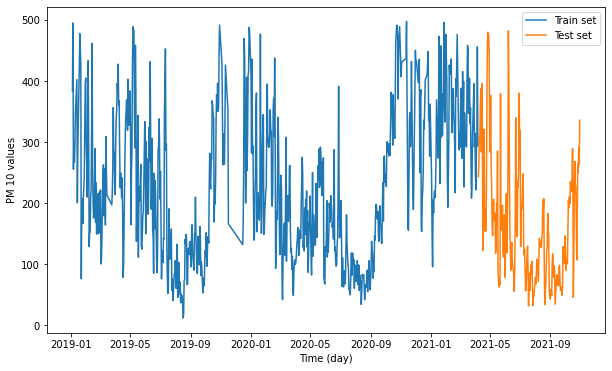

In [ ]:
train_size = int(len(df)*0.8)
train_dataset, test_dataset = df.iloc[:train_size], df.iloc[train_size:]

# Plot train and test data
plt.figure(figsize = (10, 6))
plt.plot(train_dataset.PM10)
plt.plot(test_dataset.PM10)
plt.xlabel('Time (day)')
plt.ylabel('PM 10 values')
plt.legend(['Train set', 'Test set'], loc='upper right')
#plt.savefig('C:/Users/nious/Documents/Medium/LSTM&GRU/2.jpg', format='jpg', dpi=1000)

print('Dimension of train data: ',train_dataset.shape)
print('Dimension of test data: ', test_dataset.shape)


In [ ]:
X_train = train_dataset.drop('PM10', axis = 1)
y_train = train_dataset.loc[:,['PM10']]

X_test = test_dataset.drop('PM10', axis = 1)
y_test = test_dataset.loc[:,['PM10']]

In [ ]:
# Different scaler for input and output
scaler_x = MinMaxScaler(feature_range = (0,1))
scaler_y = MinMaxScaler(feature_range = (0,1))

# Fit the scaler using available training data
input_scaler = scaler_x.fit(X_train)
output_scaler = scaler_y.fit(y_train)

# Apply the scaler to training data
train_y_norm = output_scaler.transform(y_train)
train_x_norm = input_scaler.transform(X_train)

# Apply the scaler to test data
test_y_norm = output_scaler.transform(y_test)
test_x_norm = input_scaler.transform(X_test)

In [ ]:
def create_dataset (X, y, time_steps = 1):
    Xs, ys = [], []
    
    for i in range(len(X)-time_steps):
        v = X[i:i+time_steps, :]
        Xs.append(v)
        ys.append(y[i+time_steps])
        
    return np.array(Xs), np.array(ys)


TIME_STEPS = 30

X_test, y_test = create_dataset(test_x_norm, test_y_norm, TIME_STEPS)
X_train, y_train = create_dataset(train_x_norm, train_y_norm, TIME_STEPS)
print('X_train.shape: ', X_test.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape) 
print('y_test.shape: ', y_train.shape)

X_train.shape:  (177, 30, 9)
y_train.shape:  (798, 1)
X_test.shape:  (177, 30, 9)
y_test.shape:  (798, 1)


In [ ]:
# BiLSTM model
model_bilstm = Sequential()
model_bilstm.add(Bidirectional(LSTM(32, activation='relu', return_sequences=True),input_shape=(X_train.shape[1], X_train.shape[2])))
model_bilstm.add(Bidirectional(LSTM(16, activation='relu')))
model_bilstm.add(Dense(y_train.shape[1]))

model_bilstm.compile(loss='mse', optimizer='adam')

# LSTM Model
model_lstm = Sequential()
model_lstm.add(LSTM(32, activation='relu', return_sequences = True, input_shape = [X_train.shape[1], X_train.shape[2]])) 
model_lstm.add(Dropout(0.1))
model_lstm.add(LSTM(16, activation='relu', return_sequences=False))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(y_train.shape[1])) 

model_lstm.compile(loss='mean_squared_error', optimizer='adam')

# GRU model
model_gru = Sequential()
model_gru.add(GRU(32, activation='relu', return_sequences = True, input_shape = [X_train.shape[1], X_train.shape[2]])) 
model_gru.add(Dropout(0.1))
model_gru.add(GRU(16, activation='relu', return_sequences=False))
model_gru.add(Dropout(0.2))
model_gru.add(Dense(y_train.shape[1])) 

model_gru.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
# Fit BiLSTM, LSTM and GRU
def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10)

    # shuffle = False because the order of the data matters
    history = model.fit(X_train, y_train, epochs = 100, validation_split = 0.1,
                    batch_size = 64, shuffle = False, callbacks = [early_stop], verbose=2)
    return history

history_bilstm = fit_model(model_bilstm)
history_lstm = fit_model(model_lstm)
history_gru = fit_model(model_gru)

Epoch 1/100
12/12 - 5s - loss: 0.2040 - val_loss: 0.2699 - 5s/epoch - 454ms/step
Epoch 2/100
12/12 - 1s - loss: 0.0545 - val_loss: 0.0638 - 540ms/epoch - 45ms/step
Epoch 3/100
12/12 - 1s - loss: 0.0588 - val_loss: 0.1269 - 547ms/epoch - 46ms/step
Epoch 4/100
12/12 - 1s - loss: 0.0444 - val_loss: 0.0960 - 531ms/epoch - 44ms/step
Epoch 5/100
12/12 - 1s - loss: 0.0418 - val_loss: 0.0758 - 535ms/epoch - 45ms/step
Epoch 6/100
12/12 - 1s - loss: 0.0419 - val_loss: 0.0866 - 532ms/epoch - 44ms/step
Epoch 7/100
12/12 - 1s - loss: 0.0399 - val_loss: 0.0775 - 566ms/epoch - 47ms/step
Epoch 8/100
12/12 - 1s - loss: 0.0396 - val_loss: 0.0783 - 588ms/epoch - 49ms/step
Epoch 9/100
12/12 - 1s - loss: 0.0387 - val_loss: 0.0775 - 550ms/epoch - 46ms/step
Epoch 10/100
12/12 - 1s - loss: 0.0380 - val_loss: 0.0755 - 518ms/epoch - 43ms/step
Epoch 11/100
12/12 - 1s - loss: 0.0374 - val_loss: 0.0745 - 531ms/epoch - 44ms/step
Epoch 12/100
12/12 - 1s - loss: 0.0368 - val_loss: 0.0725 - 529ms/epoch - 44ms/step
Epo

### Plot train loss vs validation loss 

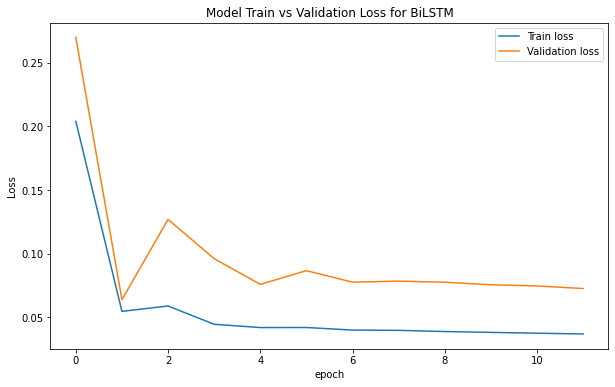

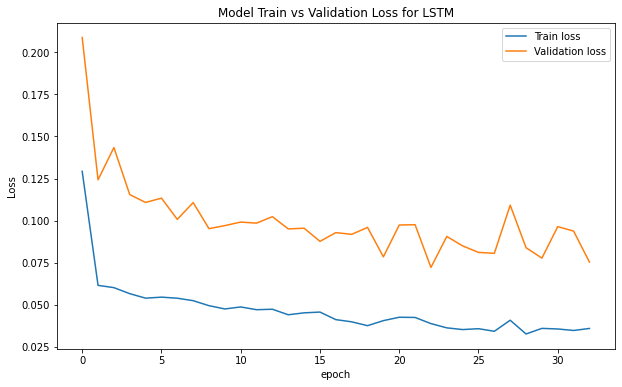

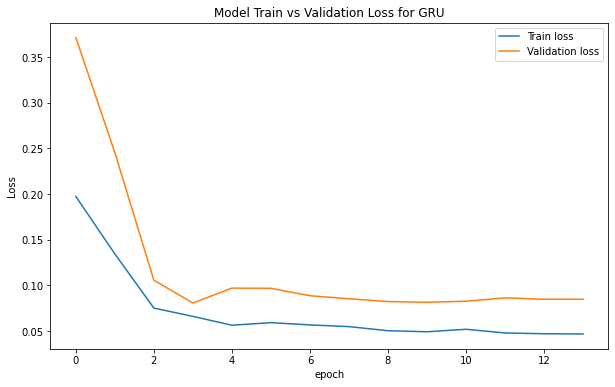

In [ ]:
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')
    #plt.savefig('C:/Users/nious/Documents/Medium/LSTM&GRU/loss_'+model_name+'.jpg', format='jpg', dpi=1000)

plot_loss (history_bilstm, 'BiLSTM')
plot_loss (history_lstm, 'LSTM')
plot_loss (history_gru, 'GRU')

In [ ]:
# Note that I have to use scaler_y
y_test = scaler_y.inverse_transform(y_test)
y_train = scaler_y.inverse_transform(y_train)

In [ ]:
def prediction(model):
    prediction = model.predict(X_test)
    prediction = scaler_y.inverse_transform(prediction)
    return prediction
    
prediction_bilstm = prediction(model_bilstm)
prediction_lstm = prediction(model_lstm)
prediction_gru = prediction(model_gru)


6/6 [==============================] - 0s 8ms/step


## Plot true future vs prediction

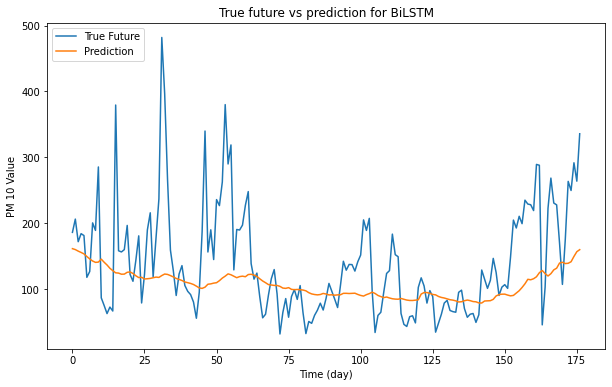

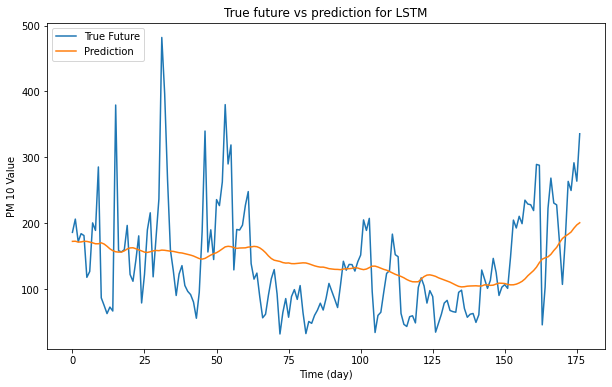

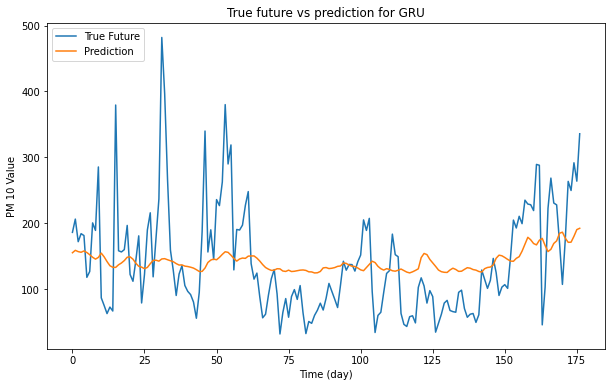

In [ ]:
def plot_future(prediction, model_name, y_test):
    
    plt.figure(figsize=(10, 6))
    
    range_future = len(prediction)

    plt.plot(np.arange(range_future), np.array(y_test), label='True Future')
    plt.plot(np.arange(range_future), np.array(prediction),label='Prediction')

    plt.title('True future vs prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Time (day)')
    plt.ylabel('PM 10 Value')
    #plt.savefig('C:/Users/nious/Documents/Medium/LSTM&GRU/predic_'+model_name+'.jpg', format='jpg', dpi=1000)
    
    
plot_future(prediction_bilstm, 'BiLSTM', y_test)
plot_future(prediction_lstm, 'LSTM', y_test)
plot_future(prediction_gru, 'GRU', y_test)

## Calculate RMSE and MAE

In [ ]:
# Define a function to calculate MAE and RMSE
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()

    print(model_name + ':')
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('')


evaluate_prediction(prediction_bilstm, y_test, 'Bidirectional LSTM')
evaluate_prediction(prediction_lstm, y_test, 'LSTM')
evaluate_prediction(prediction_gru, y_test, 'GRU')


Bidirectional LSTM:
Mean Absolute Error: 56.2904
Root Mean Square Error: 80.4355

LSTM:
Mean Absolute Error: 56.9033
Root Mean Square Error: 73.7910

GRU:
Mean Absolute Error: 57.5561
Root Mean Square Error: 74.0104



Results show that the **LSTM** has the best performance compared to BiLSTM and GRU. So I use LSTM model to forecast.

# Forecast 


In [ ]:
# Import climate data projection
newinput = pd.read_csv('drive/MyDrive/Colab Notebooks/check.csv', parse_dates=['date'], index_col = 'date')

# Order of the variable are important
X_new = newinput.loc['2019-01-01':'2021-01-01',:] 
X_new

,PM2dot5,NO,NO2,NOx,NH3,SO2,CO,Ozone,Wind speed
date,,,,,,,,,
2019-01-01,581.72,66.69,100.93,146.20,73.21,23.52,2.98,20.38,0.30
2019-01-02,631.64,98.53,116.32,176.16,84.44,22.56,3.66,20.94,0.38
2019-01-03,605.65,37.34,91.10,114.19,98.68,18.90,3.13,19.11,0.47
2019-01-04,510.71,38.64,72.73,70.16,77.60,13.05,3.07,10.20,0.44
2019-01-05,502.12,61.34,78.75,89.64,72.41,17.32,3.10,21.11,0.72
...,...,...,...,...,...,...,...,...,...
2020-12-28,362.54,35.77,105.60,85.32,40.78,6.71,1.19,9.04,0.47
2020-12-29,377.35,44.13,109.92,94.43,47.89,6.06,1.23,7.05,0.46
2020-12-30,344.56,43.28,105.68,91.49,53.18,5.98,1.53,6.43,0.46


In [ ]:
# Plot histoy and future data
def plot_history_future(y_train, prediction, model_name):
    
    plt.figure(figsize=(10, 6))
    
    range_history = len(y_train)
    range_future = list(range(range_history, range_history + len(prediction)))

    plt.plot(np.arange(range_history), np.array(y_train), label='History')
    plt.plot(range_future, np.array(prediction),label='Prediction')

    plt.title('History and prediction for ' + model_name)
    plt.legend(loc='upper right')
    plt.xlabel('Time (day)')
    plt.ylabel('PM 10 Value')
    #plt.savefig('C:/Users/nious/Documents/Medium/LSTM&GRU/3.jpg', format='jpg', dpi=1000)


22/22 [==============================] - 0s 11ms/step


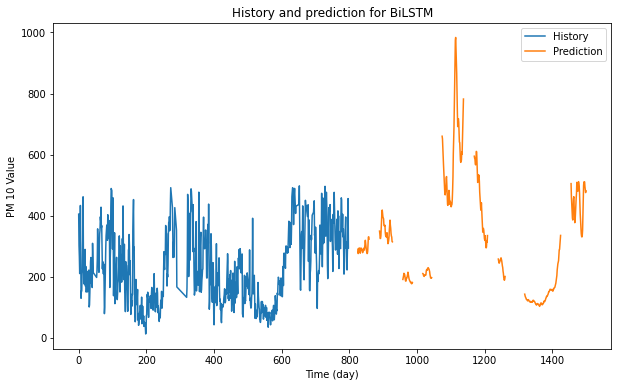

In [ ]:
def forecast(X_input, time_steps):
    # Scale the unseen input with the scaler fitted on the training data
    X = input_scaler.transform(X_input)
    # Reshape unseen data to a 3D input
    Xs = []
    for i in range(len(X) - time_steps):
        v = X[i:i+time_steps, :]
        Xs.append(v)
        
    X_transformed = np.array(Xs)

    # Make prediction for unseen data using LSTM model 
    prediction = model_bilstm.predict(X_transformed)
    prediction_actual = scaler_y.inverse_transform(prediction)
    return prediction_actual


prediction = forecast(X_new, TIME_STEPS)
plot_history_future(y_train, prediction,'BiLSTM')